In [1]:
import matplotlib.pyplot as plt
import numpy as np

import DissimilarityMetrics
import ChannelChartingCore
import Evaluation

2024-10-13 20:24:52.949372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 20:24:53.710608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import dichasus_cf0x

2024-10-13 20:24:55.196641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-13 20:24:55.236287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-13 20:24:55.236676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

cutting 0
(4, 2, 4, 1024)
cutting 0
(4, 2, 4, 1024)
cutting 0
(4, 2, 4, 1024)
TOOK (1, 2, 4, 13)
cutting 1
(4, 2, 4, 1024)
cutting 1
(4, 2, 4, 1024)
cutting 1
(4, 2, 4, 1024)
TOOK (1, 2, 4, 13)
cutting 2
(4, 2, 4, 1024)
cutting 2
(4, 2, 4, 1024)
cutting 2
(4, 2, 4, 1024)
TOOK (1, 2, 4, 13)
cutting 3
(4, 2, 4, 1024)
cutting 3
(4, 2, 4, 1024)
cutting 3
(4, 2, 4, 1024)
TOOK (1, 2, 4, 13)


**Remove CSI from all antenna arrays except array...**

In [3]:
b=2

In [4]:
# Loading datapoints from file may take some time

groundtruth_positions = []
csi_time_domain_onearray = []
timestamps = []

for csi, pos, time in dichasus_cf0x.singlearray_trainingsets[b-1].batch(1000):
    print(csi.numpy().shape)
    csi_time_domain_onearray.append(csi.numpy())
    groundtruth_positions.append(pos.numpy())
    timestamps.append(time.numpy())

csi_time_domain_onearray = np.concatenate(csi_time_domain_onearray)
groundtruth_positions = np.concatenate(groundtruth_positions)
timestamps = np.concatenate(timestamps)

MEASUREMENT_INTERVAL = 0.048
timestamps = timestamps - timestamps[0]
timestamps = np.round(timestamps / MEASUREMENT_INTERVAL) * MEASUREMENT_INTERVAL

(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(1000, 1, 2, 4, 13)
(851, 1, 2, 4, 13)


(2, 4, 13)


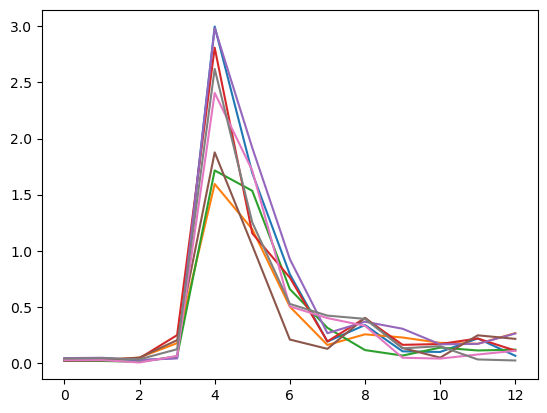

In [5]:
for array in csi_time_domain_onearray[0]:
    print(array.shape)
    for row in array:
        for antenna in row:
            plt.plot(np.abs(antenna))
plt.show()

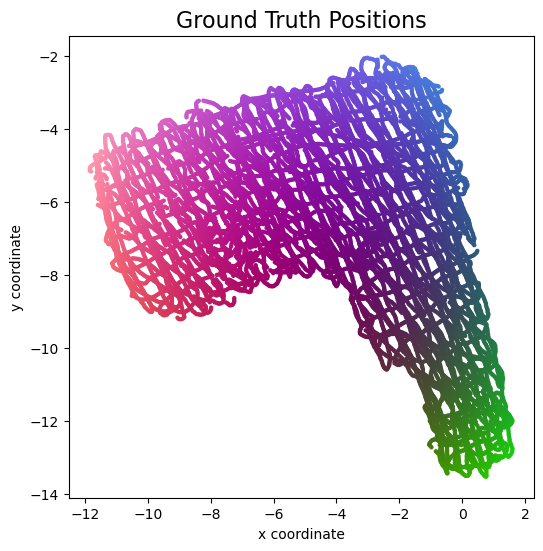

In [6]:
Evaluation.plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")

In [7]:
def mean_variance_from_delta_adp(delta_adp):
    mean = np.where(delta_adp < 1, 0,
           np.where(np.logical_and(delta_adp >= 1, delta_adp < 3), 0.01 * delta_adp + 0.01, 
           np.where(delta_adp > 3, np.inf, np.nan)))

    variance = np.where(delta_adp < 1, 0.0001,
       np.where(np.logical_and(delta_adp >= 1, delta_adp < 3), 0.0002 + 0.00005 * delta_adp, 
       np.where(delta_adp > 3, 10000, np.nan)))

    return mean, variance

adp_metric = DissimilarityMetrics.ADPDissimilarityMetric(csi_time_domain_onearray, mean_variance_from_delta_adp)

In [8]:
print(adp_metric.adp_distance_mean)

[[0.         0.         0.03582016 ...        inf        inf        inf]
 [0.         0.                inf ...        inf        inf        inf]
 [0.03582016        inf 0.         ...        inf        inf        inf]
 ...
 [       inf        inf        inf ... 0.         0.         0.        ]
 [       inf        inf        inf ... 0.         0.         0.        ]
 [       inf        inf        inf ... 0.         0.         0.        ]]


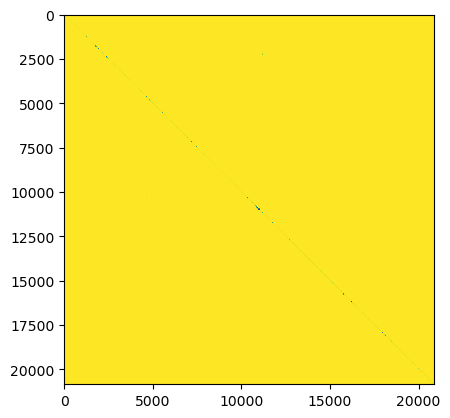

In [9]:
plt.imshow(np.where(adp_metric.adp_distance_mean != np.inf, adp_metric.adp_distance_mean, 100))
plt.show()

In [10]:
# For the single-antenna setup we assume a lower variance in the velocity model so that
# the channel charting algorithm relies more on velocity information.
velocity_mean = 0.235
velocity_variance = 0.0015

# Make worste-case assumption of perfectly correlated velocities. This maximizes the variance.
velocity_metric = DissimilarityMetrics.VelocityDissimilarityMetric(velocity_mean, velocity_variance, True, timestamps)

In [11]:
GDM = ChannelChartingCore.GaussianDissimilarityModel([adp_metric, velocity_metric], enable_path_contraction = False)
GDM.generate_short_paths(realization_count = 8)

  0%|          | 0/8 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Determining longest short path...


Computing longest paths:   0%|          | 0/40000 [00:00<?, ?it/s]

Preparing tasks:   0%|          | 0/40000 [00:00<?, ?it/s]

Starting processes:   0%|          | 0/32 [00:00<?, ?it/s]

Longest short path has 325 hops


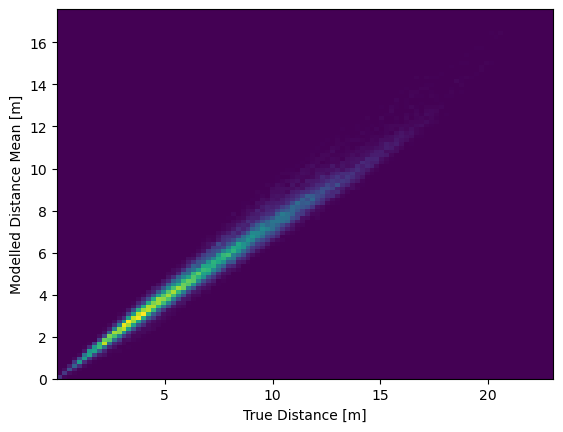

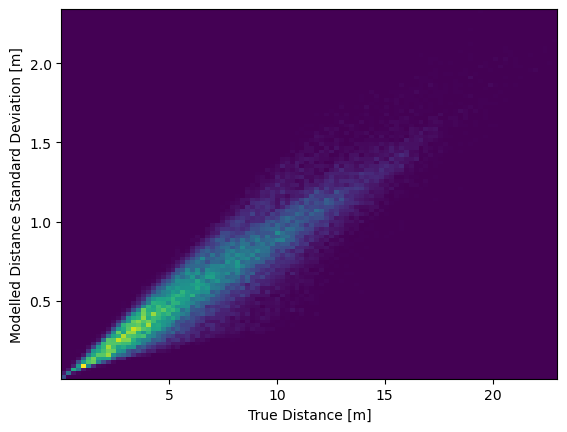

In [12]:
paths, path_hops, paths_d_mean, paths_d_variance = GDM.get_random_short_paths(50000)
groundtruth_distance_matrix = np.sqrt(np.sum((groundtruth_positions[:,np.newaxis,:] - groundtruth_positions[np.newaxis,:,:])**2, axis = -1))
groundtruth_dist = np.sum(groundtruth_distance_matrix[paths[:,:-1], paths[:,1:]], axis = 1).flatten()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Mean [m]")
plt.hist2d(groundtruth_dist, paths_d_mean, bins = 100)
plt.show()

plt.xlabel("True Distance [m]")
plt.ylabel("Modelled Distance Standard Deviation [m]")
plt.hist2d(groundtruth_dist, np.sqrt(paths_d_variance), bins = 100)
plt.show()

In [29]:
MIN_BATCH_SIZE = 2500
MAX_BATCH_SIZE = 3500
LEARNING_RATE_INITIAL = 2e-2
LEARNING_RATE_FINAL = 1e-2
MIN_PATHHOPS = 3
MAX_PATHHOPS = 8
TRAINING_BATCHES = 2600
ACCELERATION_MEAN = 0.8
ACCELERATION_VARIANCE = 1.7
ACCELERATION_WEIGHT = 0.04

#ACCELERATION_WEIGHT = 0.04 --> MAE = 0.9688
#ACCELERATION_WEIGHT = 0.00 --> MAE = 1.1641

# Now velocity_variance = 0.002 --> MAE = 0.7885m, wow! Lower velocity variance definitely better!
# ACCELERATION_WEIGHT = 0.04 --> MAE = 0.7114
# ACCELERATION_WEIGHT = 0.01 --> MAE = 0.7564
# ACCELERATION_WEIGHT = 0.02, MIN_PATHHOPS = 2, MAX_PATHHOPS = 4 --> MAE = 0.8343

# Now velocity_variance = 0.001
# ACCELERATION_WEIGHT = 0.04, MIN_PATHHOPS = 1, MAX_PATHHOPS = 10 --> MAE = 0.7101
# MAX_PATHHOPS = 5 --> MAE = 0.7650
# MAX_PATHHOPS = 20 --> MAE = 0.7869

# Now velocity_variance = 0.002
# MAX_PATHHOPS = 20 --> MAE = 0.943m
# MAX_PATHHOPS = 10, BATCH_SIZE = 4000 --> MAE = 0.898m
# MAX_PATHHOPS = 5, BATCH_SIZE = 4000, ACCELERATION_MEAN = 0.4 --> MAE = whatever, bad

# Now velocity_variance = 0.002, but NO PATH CONTRACTION
# MAX_PATHHOPS = 5, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6879
# MIN_PATHHOPS = 2, MAX_PATHHOPS = 4, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.7440

# Now velocity_variance = 0.0015
# MIN_PATHHOPS = 1, MAX_PATHHOPS = 5, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6681

# Now velocity_variance = 0.0015, but number of path hops is random!
# MIN_PATHHOPS = 1, MAX_PATHHOPS = 10, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6385, wow!!!
# MIN_PATHHOPS = 1, MAX_PATHHOPS = 20, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.7489
# MIN_PATHHOPS = 5, MAX_PATHHOPS = 10, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6716
# MIN_PATHHOPS = 3, MAX_PATHHOPS = 8, BATCH_SIZE = 3000, ACCELERATION_MEAN = 0.8 --> MAE = 0.6211, wow!!!
# MIN_PATHHOPS = 3, MAX_PATHHOPS = 8, LEARNING_RATE_INITIAL = 2e-2, LEARNING_RATE_FINAL = 4e-3 --> MAE = 0.6694
# MIN_PATHHOPS = 3, MAX_PATHHOPS = 8, LEARNING_RATE_INITIAL = 2e-2, LEARNING_RATE_FINAL = 1e-2 --> MAE = 0.6814
# same as above, but BATCH_SIZE = 6000 (instead of 3000) --> MAE = 0.8514

Pre-computing training paths:   0%|          | 0/2605 [00:00<?, ?it/s]

Preparing multiprocessing inputs:   0%|          | 0/2605 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/32 [00:00<?, ?it/s]

 198/2600 [=>............................] - ETA: 1:00 - loss: 16.3968 - metric: 0.0000e+00

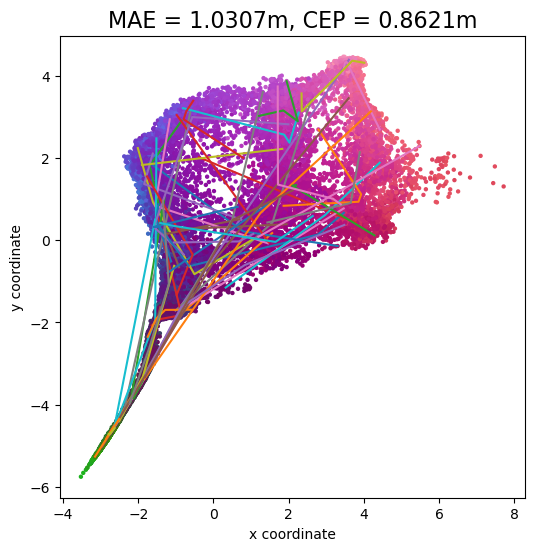

 398/2600 [===>..........................] - ETA: 59s - loss: 11.8610 - metric: 0.0000e+00

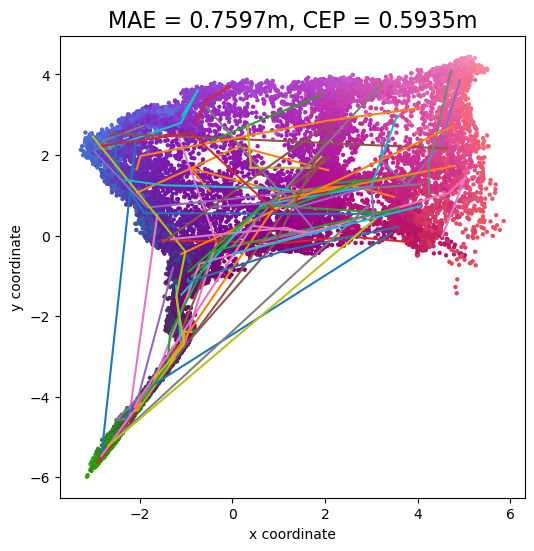

 599/2600 [=====>........................] - ETA: 53s - loss: 9.7101 - metric: 0.0000e+00

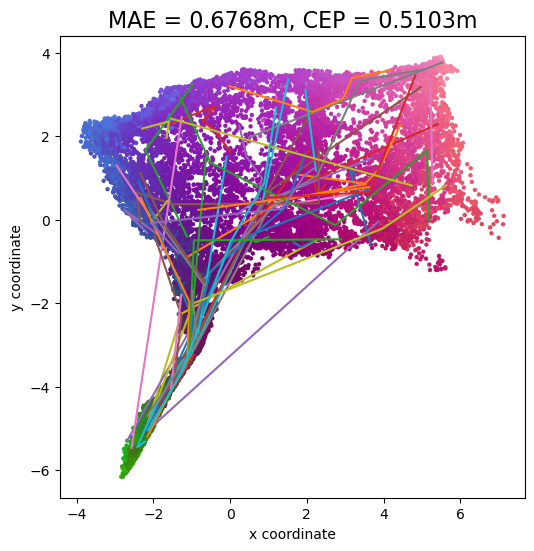

 798/2600 [========>.....................] - ETA: 47s - loss: 8.4957 - metric: 0.0000e+00

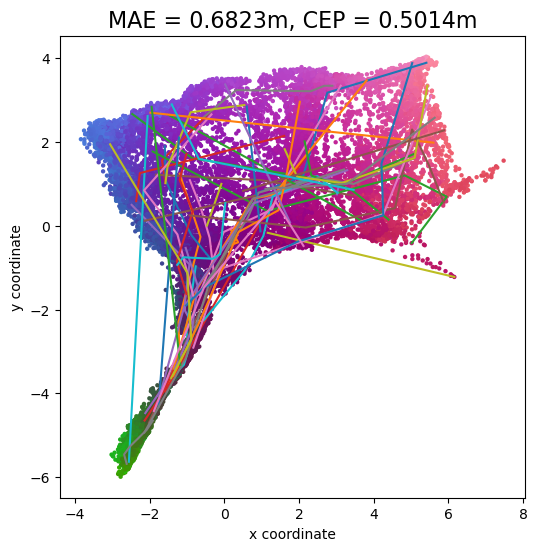

 998/2600 [==========>...................] - ETA: 42s - loss: 7.5998 - metric: 0.0000e+00

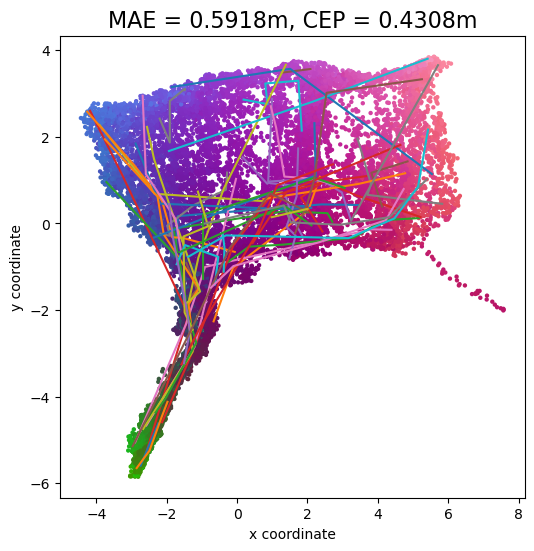

1198/2600 [============>.................] - ETA: 37s - loss: 6.9413 - metric: 0.0000e+00

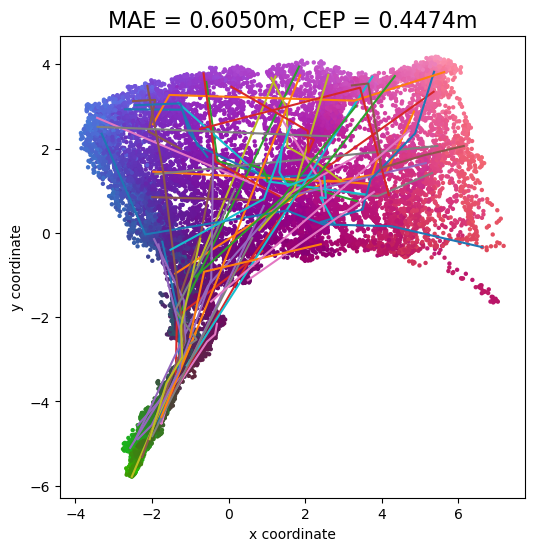

1398/2600 [===============>..............] - ETA: 31s - loss: 6.4301 - metric: 0.0000e+00

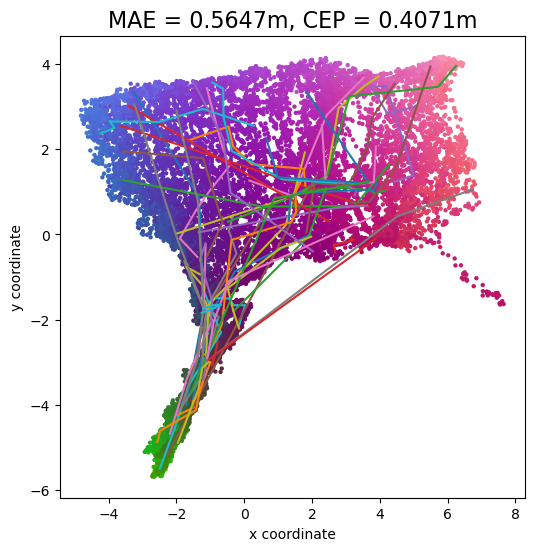

1598/2600 [=================>............] - ETA: 26s - loss: 5.9870 - metric: 0.0000e+00

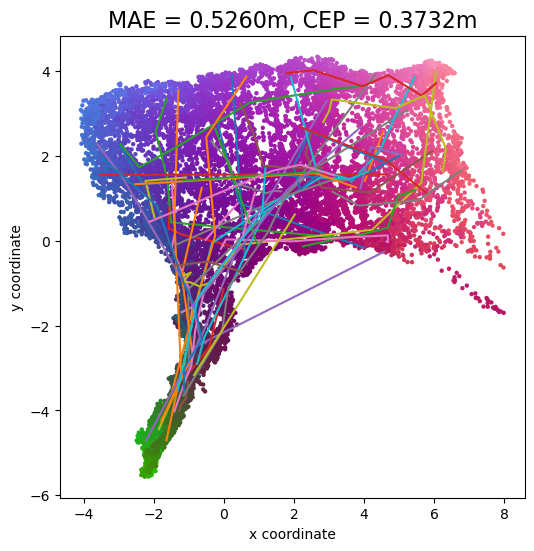

1799/2600 [===================>..........] - ETA: 21s - loss: 5.6194 - metric: 0.0000e+00

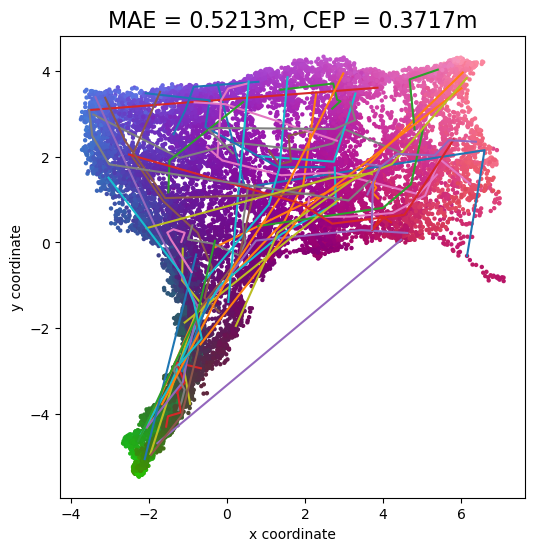

1998/2600 [======================>.......] - ETA: 15s - loss: 5.2984 - metric: 0.0000e+00

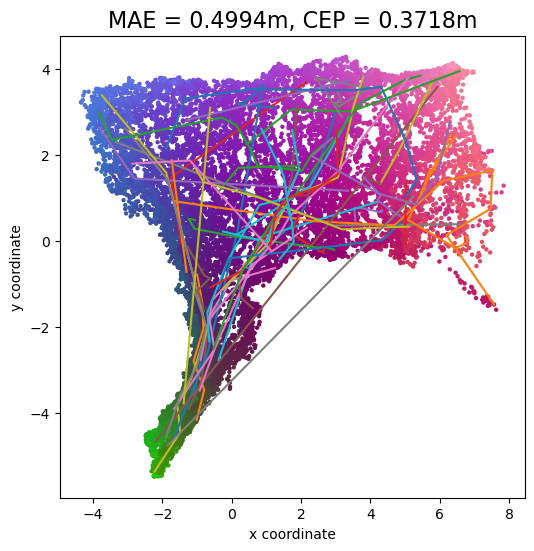

2199/2600 [========================>.....] - ETA: 10s - loss: 5.0028 - metric: 0.0000e+00

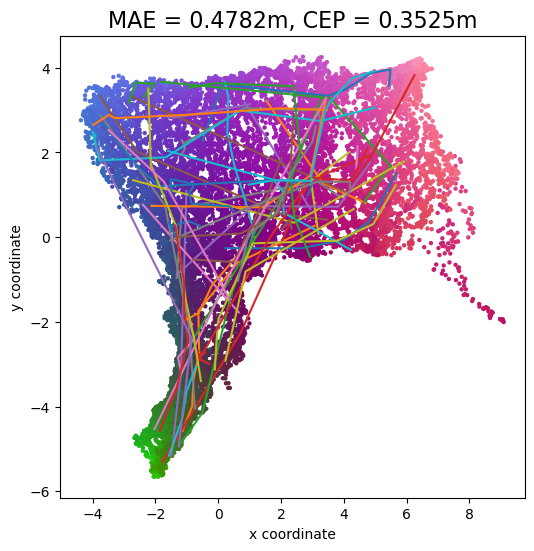

2398/2600 [==========================>...] - ETA: 5s - loss: 4.7394 - metric: 0.0000e+00

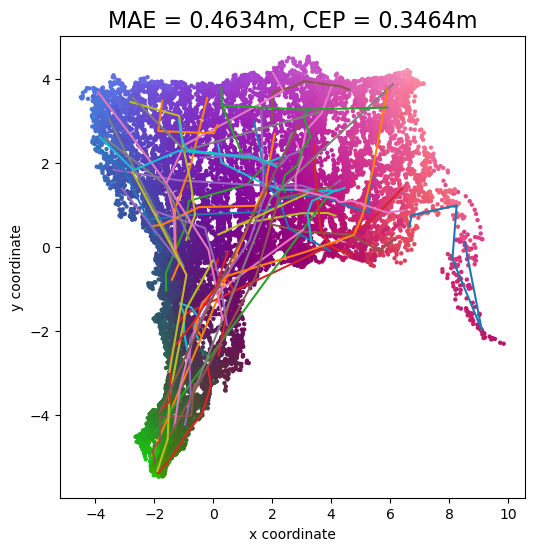

2599/2600 [============================>.] - ETA: 0s - loss: 4.5153 - metric: 0.0000e+00

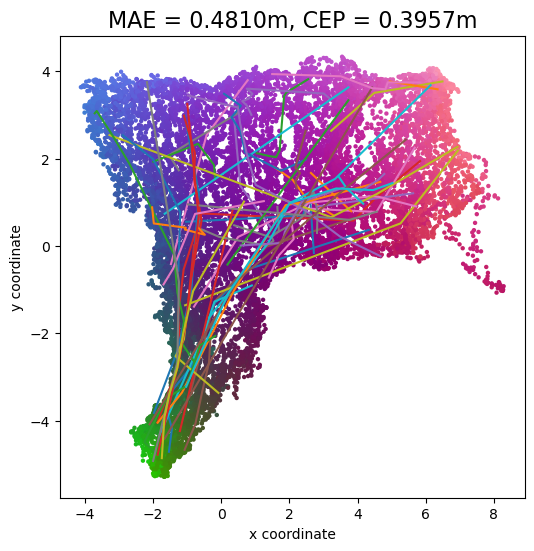

2600/2600 [==============================] - 73s 26ms/step - loss: 4.5143 - metric: 0.0000e+00


In [30]:
plot_callback = Evaluation.PlotChartCallback(groundtruth_positions, csi_time_domain_onearray.shape[0], MAX_PATHHOPS)
cc = ChannelChartingCore.ChannelChart(GDM, csi_time_domain_onearray, timestamps, min_batch_size = MIN_BATCH_SIZE, max_batch_size = MAX_BATCH_SIZE, learning_rate_initial = LEARNING_RATE_INITIAL, learning_rate_final = LEARNING_RATE_FINAL, min_pathhops = MIN_PATHHOPS, max_pathhops = MAX_PATHHOPS, randomize_pathhops = True, training_batches = TRAINING_BATCHES, plot_callback = plot_callback, acceleration_mean = ACCELERATION_MEAN, acceleration_variance = ACCELERATION_VARIANCE, acceleration_weight = ACCELERATION_WEIGHT)

In [31]:
channel_chart_positions = cc.predict(csi_time_domain_onearray)

652/652 [==============================] - 2s 2ms/step


In [32]:
ct, tw, ks = Evaluation.ct_tw_ks_on_subset(groundtruth_positions, channel_chart_positions)
print(f"CT: {ct:.4f}\nTW: {tw:.4f}\nKS: {ks:.4f}")

CT: 0.9938
TW: 0.9941
KS: 0.1217


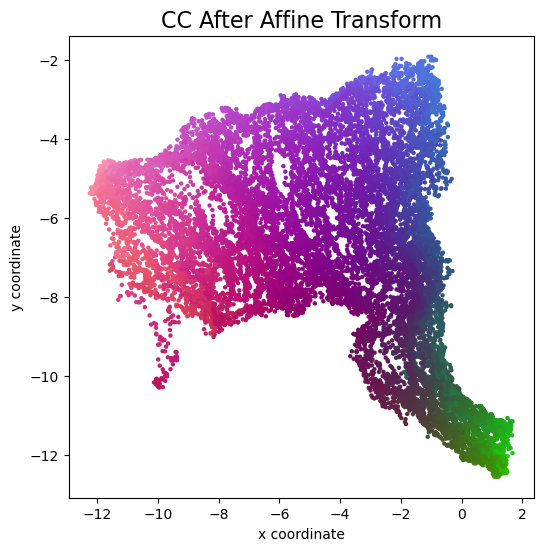

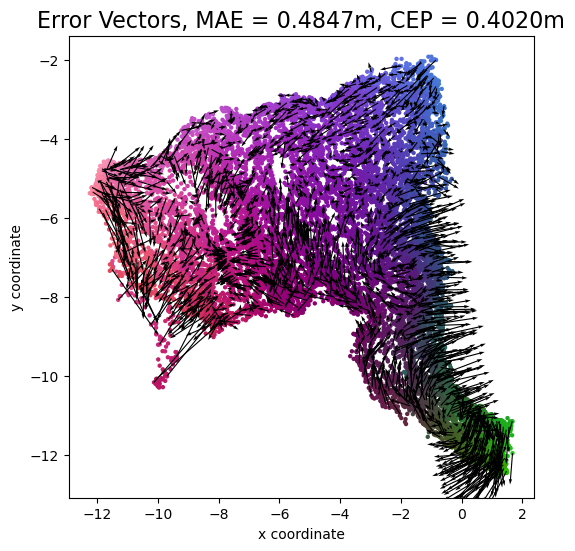

In [33]:
channel_chart_positions_transformed, errorvectors, errors, mae, cep = Evaluation.mean_absolute_error_transformed(groundtruth_positions, channel_chart_positions)
Evaluation.plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "CC After Affine Transform")

nth_errorvector = 10
Evaluation.plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = f"Error Vectors, MAE = {mae:.4f}m, CEP = {cep:.4f}m", show = False)
plt.quiver(channel_chart_positions_transformed[::nth_errorvector, 0], channel_chart_positions_transformed[::nth_errorvector, 1], errorvectors[::nth_errorvector, 0], errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()

### Evaluate on Test set

In [ ]:
test_set_groundtruth_positions = []
test_set_csi_time_domain = []

for csi, pos, time in dichasus_cf0x.singlearray_testsets[b-1].batch(1000):
    test_set_csi_time_domain.append(csi.numpy())
    test_set_groundtruth_positions.append(pos.numpy())

test_set_csi_time_domain = np.concatenate(test_set_csi_time_domain)
test_set_groundtruth_positions = np.concatenate(test_set_groundtruth_positions)

In [ ]:
test_set_channel_chart_positions = cc.predict(test_set_csi_time_domain)

In [ ]:
ts_ct, ts_tw, ts_ks = Evaluation.ct_tw_ks_on_subset(test_set_groundtruth_positions, test_set_channel_chart_positions)
print(f"CT: {ts_ct:.4f}\nTW: {ts_tw:.4f}\nKS: {ts_ks:.4f}")

In [ ]:
test_set_channel_chart_positions_transformed, ts_errorvectors, ts_errors, ts_mae, ts_cep = Evaluation.mean_absolute_error_transformed(test_set_groundtruth_positions, test_set_channel_chart_positions)
Evaluation.plot_colorized(test_set_channel_chart_positions_transformed, test_set_groundtruth_positions, title = "Test Set: CC After Affine Transform")

nth_errorvector = 10
Evaluation.plot_colorized(test_set_channel_chart_positions_transformed, test_set_groundtruth_positions, title = f"Test Set: Error Vectors, MAE = {ts_mae:.4f}m, CEP = {ts_cep:.4f}m", show = False)
plt.quiver(test_set_channel_chart_positions_transformed[::nth_errorvector, 0], test_set_channel_chart_positions_transformed[::nth_errorvector, 1], ts_errorvectors[::nth_errorvector, 0], ts_errorvectors[::nth_errorvector, 1], color = "black", angles = "xy", scale_units = "xy", scale = 1)
plt.show()